In [79]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

In [87]:
"""
Helper functions.
"""

def factors(n,k):   
    """
    Returns kth largest factor of an int. Needed for finding equally sized grids in our image.
    """
    facs = reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))
    #print("Factors of %d are :" % n, facs)
    return sorted(facs)[-k], facs


def enoughFactors(arr,minNoFactors):
    
    """
    Pads image dimensions to make dimensions have more factors if needed.
    """

    (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,0),arr.shape)
    enoughFactors = (len(rowFactors) >= minNoFactors) and (len(colFactors) >= minNoFactors)
    while enoughFactors == False:
        if len(rowFactors) < minNoFactors:
            arr = np.pad(arr,((2,0),(0,0)),"reflect")
            (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,0),arr.shape)

        if len(colFactors) < minNoFactors:
            arr = np.pad(arr,((0,0),(2,0)),"reflect")
            (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,0),arr.shape)
        
        enoughFactors = (len(rowFactors) >= minNoFactors) and (len(colFactors) >= minNoFactors)
        
    return arr

def chosenFactor(arr,factors):
    """
    Given array and set of factors of the dimensions, returns factors which are most similar aspect ratio wise
    to the array.
    """
    rowFactors,colFactors = factors
    chosenWindow = 10000
    for i in rowFactors:
        for j in colFactors:
            shape = arr.shape[0]/i,arr.shape[1]/j
            aspectRatioWin = float(shape[1])/shape[0]
            aspectRatioImg = float(arr.shape[1])/arr.shape[0]
            aspectRatioDiff = aspectRatioWin - aspectRatioImg
            if aspectRatioDiff < chosenWindow:
                chosenWindow = (i,j)

    return chosenWindow

def closestLevel(levelDims,w):
    differences = map(lambda dim: (abs(dim[1]-w), abs(dim[1]-w)),levelDims)
    areas = map(lambda levelDims: reduce(mul,levelDims),(differences))
    level = [idx for idx,area in enumerate(areas) if area == min(areas)][0]
    return level


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h/int(nrows), nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def getBoxCoords(blocksPair,level,upscaleLevel):
    
    """
    Returns information to load region of high resolution image. Given indicies blocks for x and y,
    low resolution image level and desired output level.
    """
    x = blocksPair[1]
    x1 = x[0][0]
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0]
    y2 = y[-1][0]
    #print("X",x1,x2)
    #print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    #return (upscaledX),(upscaledY)
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size, ((x1,x2),(y1,y2))

percentage255 = lambda block: np.sum(block==255).astype("float64")/block.size # Calculates percentage of array = 255.

In [72]:
"""
Main image object.
"""

class her2Image():
    def __init__(self,caseNumber,minNoFactors,threshArea):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
            
        self.level = closestLevel(self.her2.level_dimensions,1000)
        #self.level = self.nLevels - 3
        self.lowResDims = self.her2.level_dimensions[self.level] #3 is arbitrary but works
        self.lowResRGB = np.asarray(self.her2.read_region((0,0),self.level,(self.lowResDims[0],self.lowResDims[1]))) 
        self.lowRes = cv2.cvtColor(self.lowResRGB, cv2.COLOR_RGB2GRAY) # Grayscale
        self.lowResArea = reduce(mul,self.lowResDims) # Area of image
        self.mode = mstats.mode(self.lowRes,axis=None)[0]
        
        # Thresholded image
        img = cv2.GaussianBlur(self.lowRes,(47,47),0)
        ret,self.thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-4,255,1)
        
        # Padd lowRes image and thresholded to make factors 
        self.lowRes, self.thresh = [enoughFactors(arr,minNoFactors) for arr in (self.lowRes, self.thresh)]
        
        (_,rowFactors),(_,colFactors) = map(lambda dim: factors(dim,8),self.lowRes.shape)
        nrows, ncols = chosenFactor(self.lowRes,(rowFactors,colFactors))

        coordsX,coordsY = np.indices((self.lowRes.shape[0],self.lowRes.shape[1]))
        blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
        blocksThresh = blockshaped(self.thresh,nrows,ncols)
        blocksLowRes = blockshaped(self.lowRes,nrows,ncols)

        self.relaventCoords = [] # ROIs

        #featureBlocks = np.where(np.any(blocksThresh==255,axis=(1,2)))[0]
        featureBlocks = np.where(np.array([percentage255(block) for block in blocksThresh])>threshArea)[0] # Percentage covered
        for block in featureBlocks:
            self.relaventCoords.append((blocksX[block],blocksY[block]))
        
    def show(self):
        plt.imshow(self.lowResRGB)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
             
    def regionGen(self,upscaleLevel): 
        for i in range(len(self.relaventCoords)):
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(self.relaventCoords[i],self.level,upscaleLevel)
            cv2.rectangle(self.lowResRGB, (x1, y1), (x2, y2), (255,0,0), 2)
            region = np.asarray(eg.her2.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
            yield region
            


        


In [51]:
groundTruth = pd.read_csv("data/groundTruth.csv")
cols = {1: "CaseNo", 2: "HeR2 SCORE",
       3:"PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"}
groundTruthLowStain = groundTruth.loc[groundTruth.ix[:,2]<=50]
groundTruthHighStain = groundTruth.loc[groundTruth.ix[:,2]>90]
groundTruth.sort_values(by=cols[1],inplace=True)
groundTruth

,CaseNo,HeR2 SCORE,PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY
0,1,0,0
1,4,2,60
2,6,2,40
3,9,3,70
4,11,3,90
5,12,1,5
6,13,0,0
7,14,1,1
8,15,1,2
9,16,1,5


Image 1 with score of 0, percScore of 0.


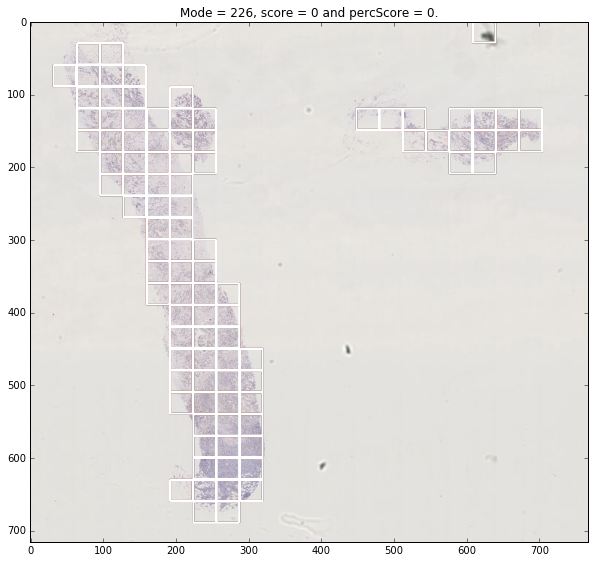

Image 4 with score of 2, percScore of 60.


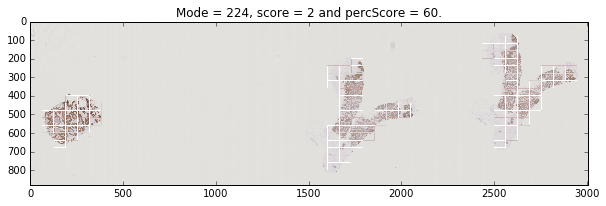

Image 6 with score of 2, percScore of 40.


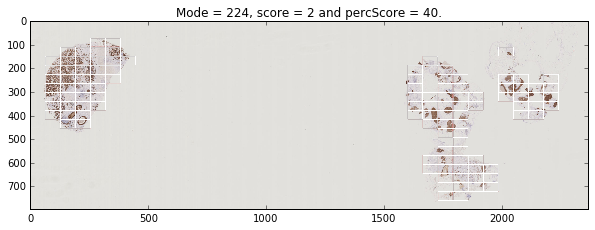

Image 9 with score of 3, percScore of 70.


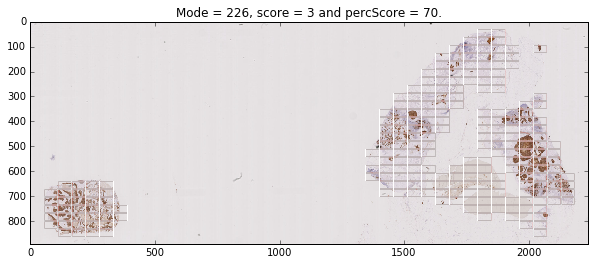

Image 11 with score of 3, percScore of 90.


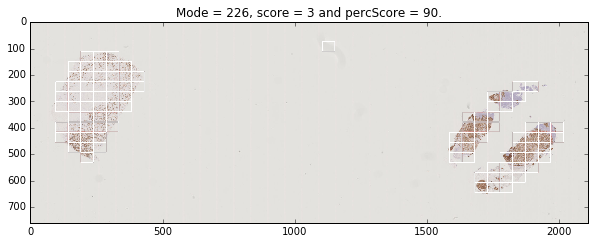

Image 12 with score of 1, percScore of 5.


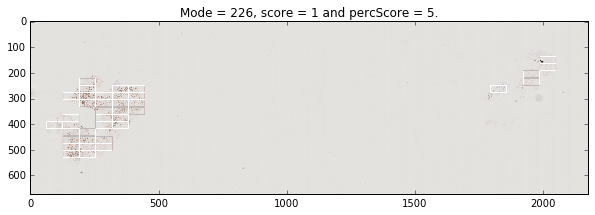

Image 13 with score of 0, percScore of 0.


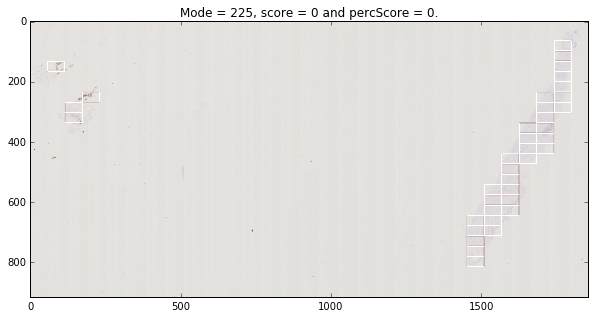

Image 14 with score of 1, percScore of 1.


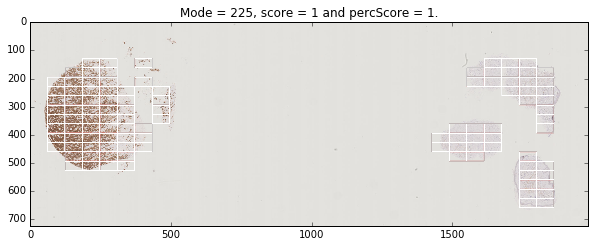

Image 15 with score of 1, percScore of 2.


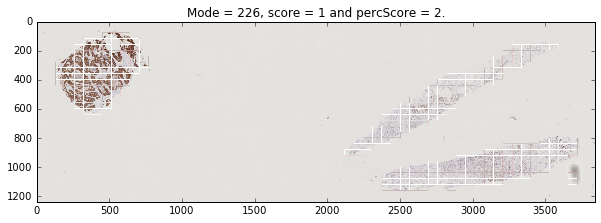

Image 16 with score of 1, percScore of 5.


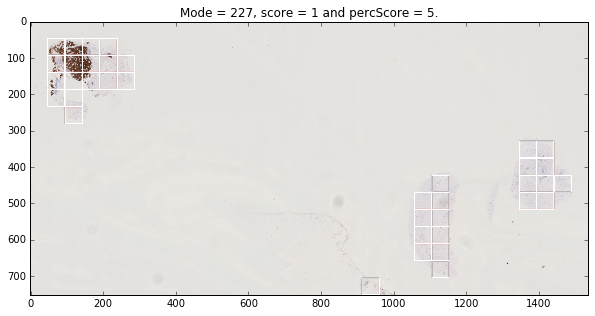

In [95]:
minNoFactors = 10
threshArea = 0.5
upscaleLevel= 2

for caseNo in groundTruth.CaseNo.values[:10]:
    eg = her2Image(caseNo,minNoFactors,threshArea)
    print("Image %d with score of %d, percScore of %d." % (caseNo,eg.score,eg.percScore))
    regions = eg.regionGen(upscaleLevel) # region object
    for region in regions:
        if np.random.uniform() < 0.00:
            plt.imshow(region)
            plt.show()
    eg.show()
